> **This file tests other methods of edge operators**
> ---

No preprocessing steps are done to the images.
Here we test the accuracy of 3 operators: Sobel, Laplacian and Prewitt to determine the most suitable edge operator.

We will be using the first 10 images as the basis for comparison.

# Imports and Data

Importing essential packages and loading image data  

In [1]:
!pip install scikit-optimize

In [2]:
import os
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
from tqdm import tqdm
import time

from PIL import Image, ImageEnhance
from skimage.util import img_as_float
from skimage.color import rgb2gray
from skimage.io import imread, imsave
from skimage.measure import shannon_entropy
from skimage.feature import local_binary_pattern
import cv2

from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from skopt import gp_minimize
from skopt.space import Categorical

from google.colab import drive

In [3]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# data_dir = #"PATH_TO_YOUR_FOLDER"

# Checking if our specified directory exists
os.path.exists(data_dir)

True

In [5]:
class BoundaryDataset(object):
    """
    Project boundary dataset wrapper

    Given the path to the root of the dataset, this class provides
    methods for loading images and ground truths.

    Attributes:

    root_dir - the root path of the dataset
    data_path - the path of the data directory within the root
    sample_names - a list of names of images
    """
    def __init__(self, root_dir='.', split='train'):
        """
        Constructor

        :param root_dir: the path to the root of the custom dataset
        :param split: 'train' or 'test'
        """
        self.root_dir = root_dir
        self.data_path = os.path.join(root_dir, split)
        self.sample_names = self._sample_names(self.data_path)

    def __len__(self):
        """
        Get the number of samples in the dataset
        :return: the number of samples
        """
        return len(self.sample_names)

    @staticmethod
    def _sample_names(directory):
        names = []
        files = os.listdir(directory)
        for fn in files:
            name, ext = os.path.splitext(fn)
            if ext.lower() == '.jpg':
                names.append(name)
        return names

    def read_image(self, name):
        """
        Load the image identified by the sample name
        :param name: the sample name
        :return: a (H,W,3) array containing the image
        """
        path = os.path.join(self.data_path, f"{name}.jpg")
        return imread(path)

    def load_boundaries(self, name):
        """
        Load the boundaries identified by the sample name
        :param name: the sample name
        :return: a list of (H,W) arrays, each of which contains a boundary ground truth
        """
        boundary_path = os.path.join(self.data_path, f"{name}.npy")
        if os.path.exists(boundary_path):
            boundaries = np.load(boundary_path, allow_pickle=True)
            return list(boundaries)
        return []

In [6]:
split = 'train'

# Load the dataset using BoundaryDataset class
train_dataset = BoundaryDataset(data_dir + "/project_data", split=split)

print(f"Data size: {len(train_dataset)}")

Data size: 200


In [7]:
selected_sample_names = train_dataset.sample_names[:10]

# Edge Dectection

## Sobel

In [8]:
def generate_edges_sobel(image):

    # Process each channel independently
    def process_channel(channel):

        grad_x = cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(channel, cv2.CV_64F, 0, 1, ksize=3)
        gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

        # Normalize the gradient magnitude to [0, 1]
        gradient_magnitude_min = np.min(gradient_magnitude)
        gradient_magnitude_max = np.max(gradient_magnitude)
        normalized_gradient = (gradient_magnitude - gradient_magnitude_min) / (gradient_magnitude_max - gradient_magnitude_min)

        return normalized_gradient

    red_edges = process_channel(image[:, :, 2])
    green_edges = process_channel(image[:, :, 1])
    blue_edges = process_channel(image[:, :, 0])

    # Combine the edges from all channels
    combined_edges = np.maximum.reduce([red_edges, green_edges, blue_edges])

    return combined_edges

Processing image: train/37073


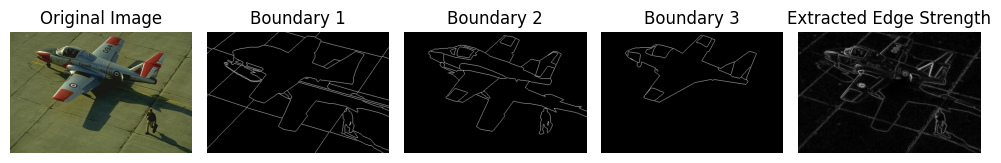

Processing image: train/140055


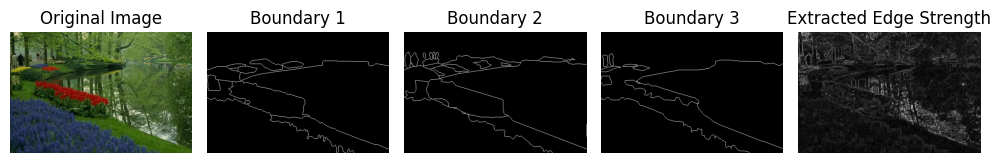

Processing image: train/118035


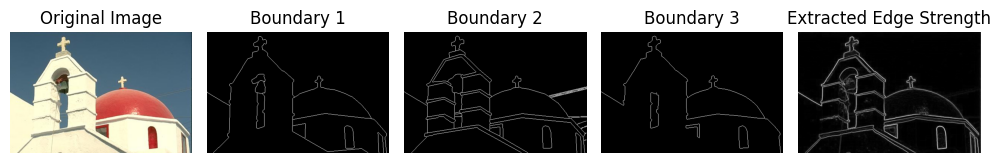

Processing image: train/159008


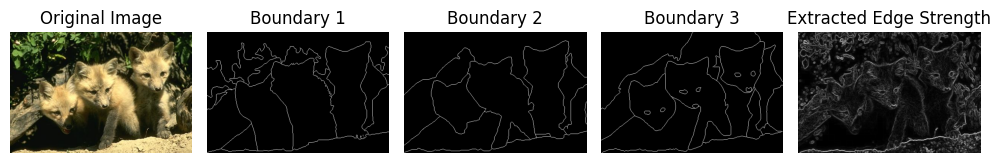

Processing image: train/78019


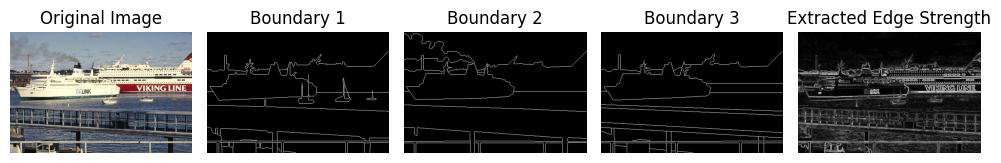

Processing image: train/314016


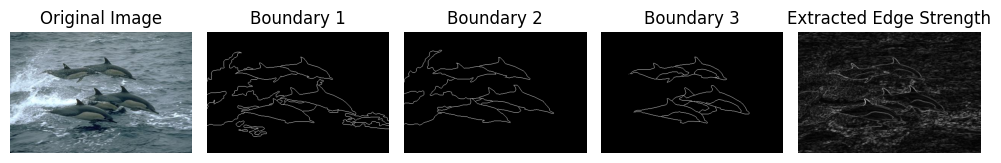

Processing image: train/254033


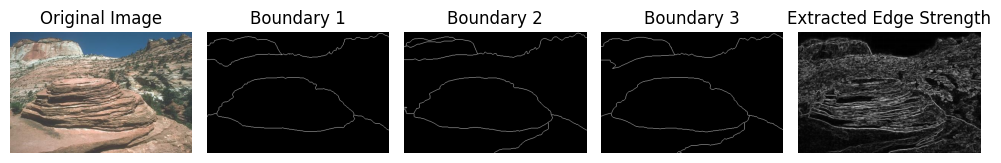

Processing image: train/189080


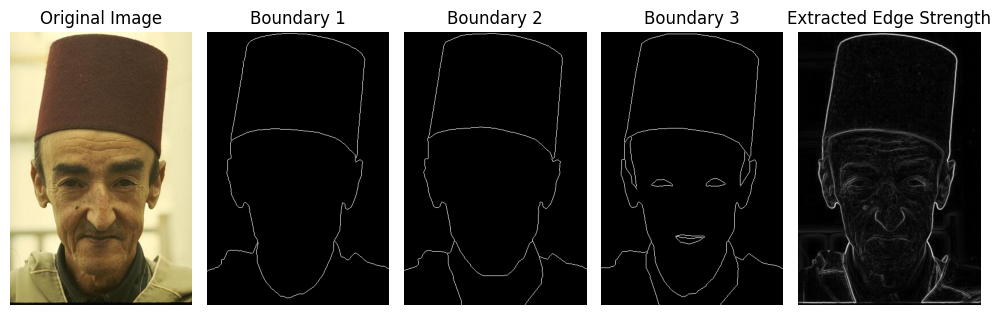

Processing image: train/8049


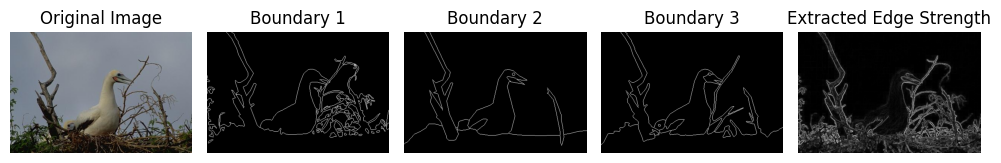

Processing image: train/12003


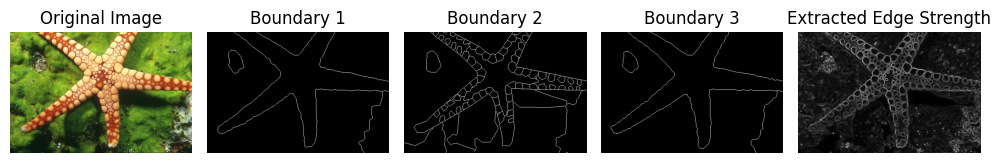

In [9]:
predictions_sobel = {}

for selected_sample_name in selected_sample_names:
    print(f"Processing image: {split}/{selected_sample_name}")
    image = train_dataset.read_image(selected_sample_name)
    boundaries = train_dataset.load_boundaries(selected_sample_name)

    # generate edges based on optimal parameters
    edges = generate_edges_sobel(image)

    # save predictions
    predictions_sobel[selected_sample_name] = edges

    # display image
    fig, ax = plt.subplots(1, 5, figsize=(10, 8))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    # display boundaries (ground truth)
    for i in range(len(boundaries)):
        ax[i + 1].imshow(boundaries[i], cmap='gray')
        ax[i + 1].set_title(f"Boundary {i + 1}")
        ax[i + 1].axis("off")
        edge_count = np.sum(boundaries[i] > 0)
        edge_density = edge_count / (boundaries[i].size)

    # display extracted edges
    ax[4].imshow(edges, cmap='gray')
    ax[4].set_title("Extracted Edge Strength")
    ax[4].axis("off")

    plt.tight_layout()
    plt.show()

# save the predictions
np.save(f'{data_dir}/method_experiment_results/predictions_train_sobel.npy', predictions_sobel)

## Laplacian

In [10]:
def generate_edges_laplacian(image):

    # Process each channel independently
    def process_channel(channel):

        laplacian_edges = cv2.Laplacian(channel, cv2.CV_64F)

        # Normalize the Laplacian output to [0, 1]
        laplacian_min = np.min(laplacian_edges)
        laplacian_max = np.max(laplacian_edges)
        normalized_laplacian = (laplacian_edges - laplacian_min) / (laplacian_max - laplacian_min)

        return normalized_laplacian

    red_edges = process_channel(image[:, :, 2])
    green_edges = process_channel(image[:, :, 1])
    blue_edges = process_channel(image[:, :, 0])

    # Combine the edges from all channels
    combined_edges = np.maximum.reduce([red_edges, green_edges, blue_edges])

    return combined_edges

Processing image: train/37073


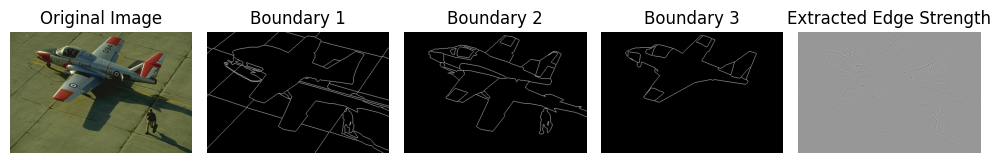

Processing image: train/140055


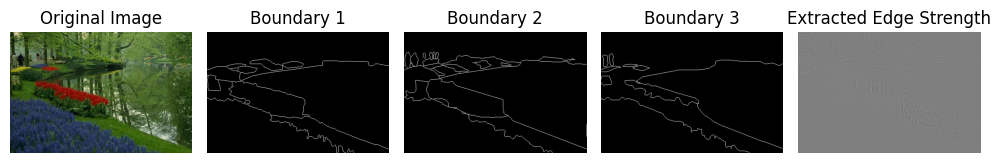

Processing image: train/118035


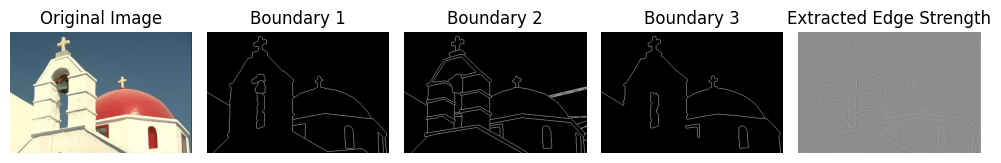

Processing image: train/159008


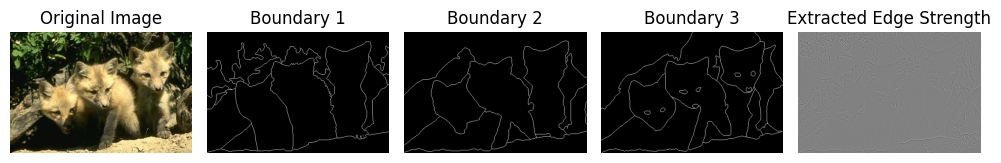

Processing image: train/78019


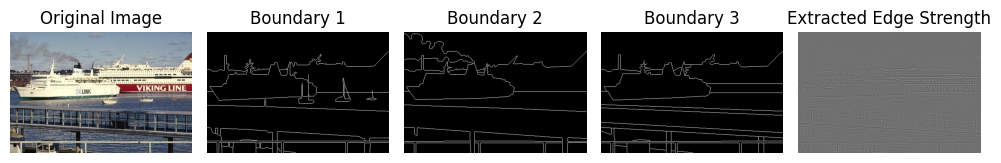

Processing image: train/314016


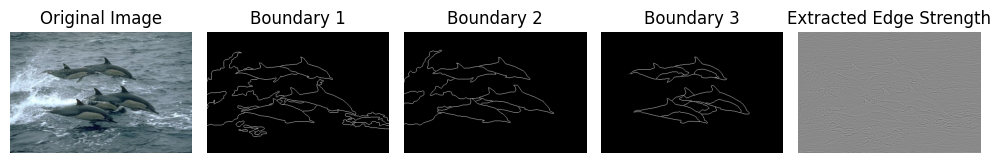

Processing image: train/254033


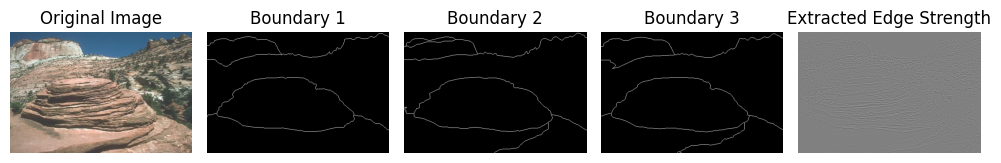

Processing image: train/189080


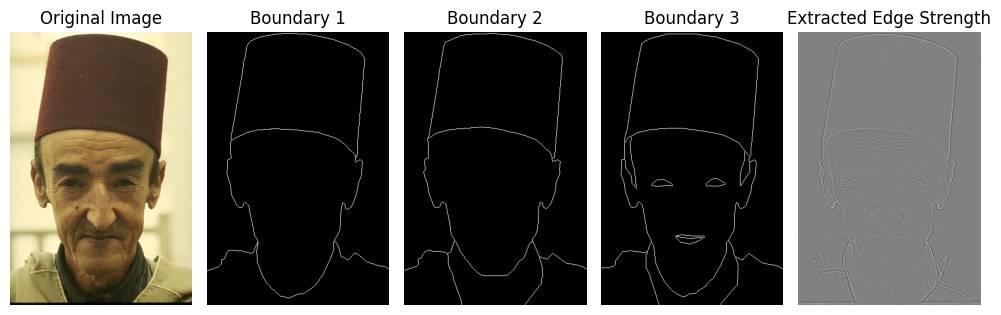

Processing image: train/8049


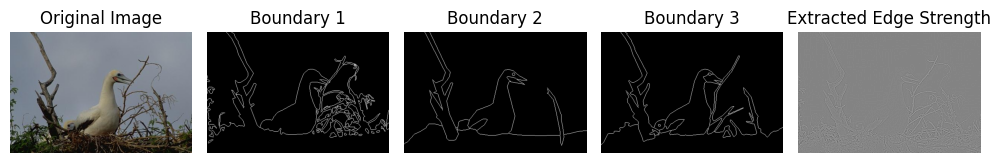

Processing image: train/12003


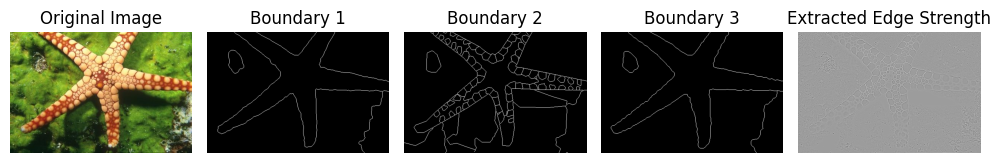

In [11]:
predictions_laplacian = {}

for selected_sample_name in selected_sample_names:
    print(f"Processing image: {split}/{selected_sample_name}")
    image = train_dataset.read_image(selected_sample_name)
    boundaries = train_dataset.load_boundaries(selected_sample_name)

    # generate edges based on optimal parameters
    edges = generate_edges_laplacian(image)

    # save predictions
    predictions_laplacian[selected_sample_name] = edges

    # display image
    fig, ax = plt.subplots(1, 5, figsize=(10, 8))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    # display boundaries (ground truth)
    for i in range(len(boundaries)):
        ax[i + 1].imshow(boundaries[i], cmap='gray')
        ax[i + 1].set_title(f"Boundary {i + 1}")
        ax[i + 1].axis("off")
        edge_count = np.sum(boundaries[i] > 0)
        edge_density = edge_count / (boundaries[i].size)

    # display extracted edges
    ax[4].imshow(edges, cmap='gray')
    ax[4].set_title("Extracted Edge Strength")
    ax[4].axis("off")

    plt.tight_layout()
    plt.show()

# save the predictions
np.save(f'{data_dir}/method_experiment_results/predictions_train_laplacian.npy', predictions_laplacian)

## Prewitt

In [12]:
# Function to generate edges for each channel (RGB) and combine them
def generate_edges_prewitt(image):

    # Process each channel independently
    def process_channel(channel):

        # Define Prewitt kernels
        prewitt_x = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
        prewitt_y = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])

        # Apply Prewitt edge detection
        grad_x = cv2.filter2D(channel, -1, prewitt_x)
        grad_y = cv2.filter2D(channel, -1, prewitt_y)

        gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

        # Normalize the gradient magnitude to [0, 1]
        gradient_magnitude_min = np.min(gradient_magnitude)
        gradient_magnitude_max = np.max(gradient_magnitude)
        normalized_gradient = (gradient_magnitude - gradient_magnitude_min) / (gradient_magnitude_max - gradient_magnitude_min)

        return normalized_gradient


    red_edges = process_channel(image[:, :, 2])
    green_edges = process_channel(image[:, :, 1])
    blue_edges = process_channel(image[:, :, 0])

    # Combine the edges from all channels
    combined_edges = np.maximum.reduce([red_edges, green_edges, blue_edges])

    return combined_edges

Processing image: train/37073


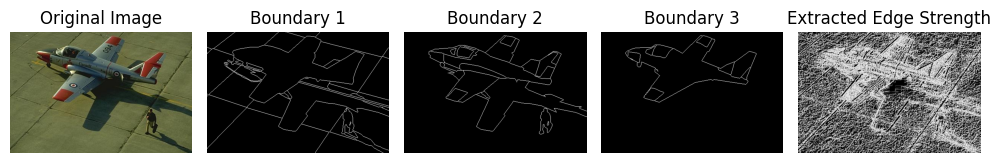

Processing image: train/140055


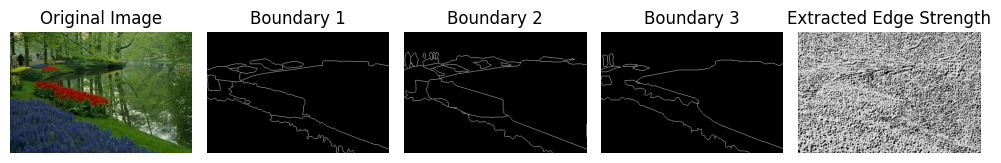

Processing image: train/118035


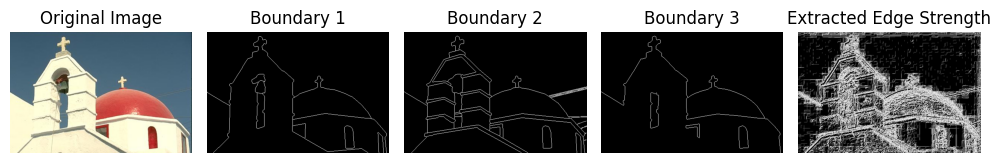

Processing image: train/159008


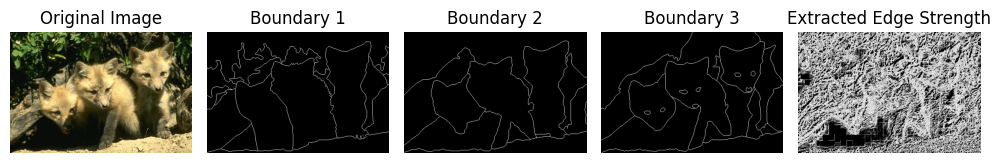

Processing image: train/78019


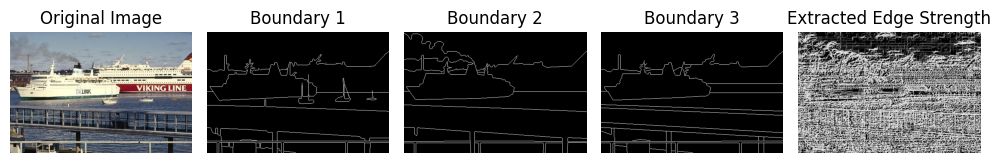

Processing image: train/314016


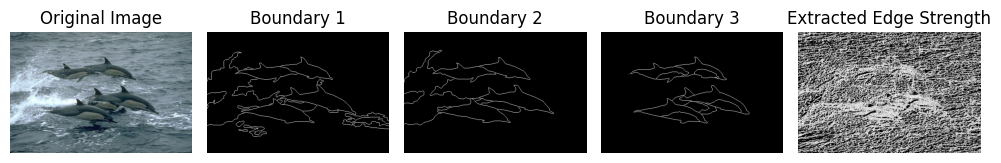

Processing image: train/254033


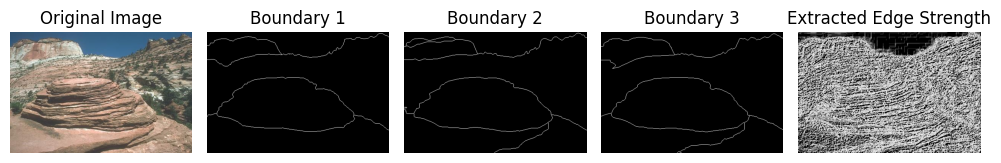

Processing image: train/189080


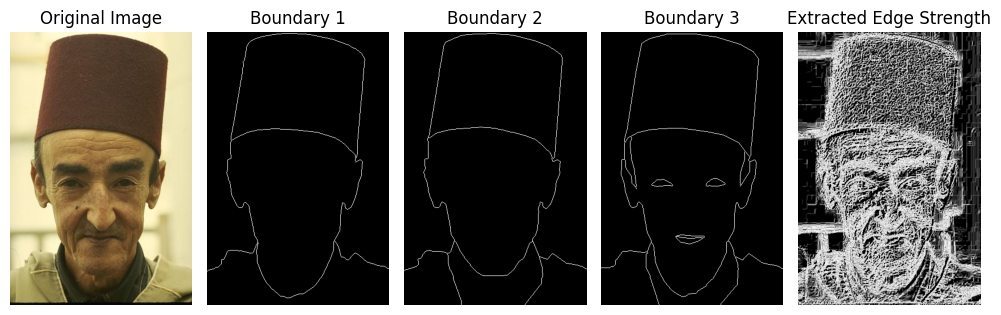

Processing image: train/8049


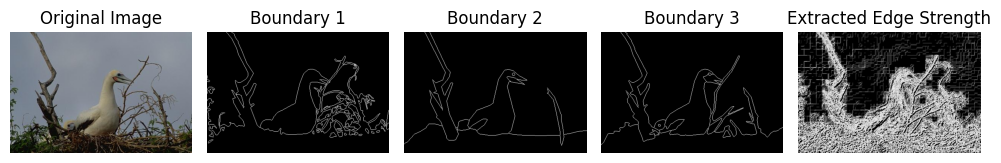

Processing image: train/12003


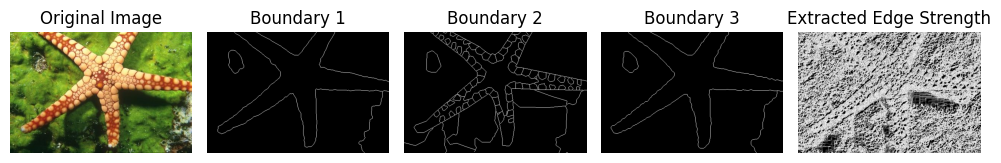

In [13]:
predictions_prewitt = {}

for selected_sample_name in selected_sample_names:
    print(f"Processing image: {split}/{selected_sample_name}")
    image = train_dataset.read_image(selected_sample_name)
    boundaries = train_dataset.load_boundaries(selected_sample_name)

    # generate edges based on optimal parameters
    edges = generate_edges_prewitt(image)

    # save predictions
    predictions_prewitt[selected_sample_name] = edges

    # display image
    fig, ax = plt.subplots(1, 5, figsize=(10, 8))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    # display boundaries (ground truth)
    for i in range(len(boundaries)):
        ax[i + 1].imshow(boundaries[i], cmap='gray')
        ax[i + 1].set_title(f"Boundary {i + 1}")
        ax[i + 1].axis("off")
        edge_count = np.sum(boundaries[i] > 0)
        edge_density = edge_count / (boundaries[i].size)

    # display extracted edges
    ax[4].imshow(edges, cmap='gray')
    ax[4].set_title("Extracted Edge Strength")
    ax[4].axis("off")

    plt.tight_layout()
    plt.show()

# save the predictions
np.save(f'{data_dir}/method_experiment_results/predictions_train_prewitt.npy', predictions_prewitt)

# Evaluating

## Setup

Setting up workspace

In [14]:
import os

# root_dir = # "PATH_TO_YOUR_FOLDER"
root_dir = "/content/drive/My Drive/03 Ewha Exchange/05 computer vision/group project final"
data_dir = os.path.join(root_dir, "project_data")

os.chdir(root_dir)
print("Current working directory:", os.getcwd())

Current working directory: /content/drive/My Drive/03 Ewha Exchange/05 computer vision/group project final


In [15]:
# !git clone https://github.com/ewha-pai/cv_project_tools.git

In [16]:
%cd cv_project_tools

/content/drive/My Drive/03 Ewha Exchange/05 computer vision/group project final/cv_project_tools


In [17]:
# !python setup.py build_ext --inplace

In [18]:
from core.dataset import BoundaryDataset
from core import evaluate_boundaries

Loading train images dataset

In [19]:
split = 'train'

dataset = BoundaryDataset(root_dir + "/project_data", split=split)

print(f"Data size: {len(dataset)}")

Data size: 200


In [20]:
thresholds = 20
apply_thinning = True

sample_names = dataset.sample_names[:10]

## Sobel Evaluation

Loading prediction npy file

In [21]:
# Load the saved predictions
predictions = np.load(os.path.join(root_dir, 'method_experiment_results/predictions_train_sobel.npy'), allow_pickle=True).item()

# Function to load the prediction for a given sample name
def load_pred(sample_name):
    # Retrieve the prediction for the given sample name from the loaded dictionary
    if sample_name in predictions:
        pred = predictions[sample_name]
        return pred
    else:
        raise KeyError(f"Sample '{sample_name}' not found in the predictions.")

In [22]:
sample_results_sobel, threshold_results_sobel, best_result_single_sobel, best_result_sobel = evaluate_boundaries.pr_evaluation(
    thresholds, sample_names, dataset.load_boundaries, load_pred, apply_thinning=apply_thinning, progress=tqdm
)

Processing samples: 100%|██████████| 10/10 [02:46<00:00, 16.67s/it]


## Laplacian Evaluation

Loading prediction npy file

In [23]:
# Load the saved predictions
predictions = np.load(os.path.join(root_dir, 'method_experiment_results/predictions_train_laplacian.npy'), allow_pickle=True).item()

# Function to load the prediction for a given sample name
def load_pred(sample_name):
    # Retrieve the prediction for the given sample name from the loaded dictionary
    if sample_name in predictions:
        pred = predictions[sample_name]
        return pred
    else:
        raise KeyError(f"Sample '{sample_name}' not found in the predictions.")

In [24]:
sample_results_laplacian, threshold_results_laplacian, best_result_single_laplacian, best_result_laplacian = evaluate_boundaries.pr_evaluation(
    thresholds, sample_names, dataset.load_boundaries, load_pred, apply_thinning=apply_thinning, progress=tqdm
)

Processing samples: 100%|██████████| 10/10 [04:03<00:00, 24.37s/it]


## Prewitt Evaluation

Loading prediction npy file

In [25]:
# Load the saved predictions
predictions = np.load(os.path.join(root_dir, 'method_experiment_results/predictions_train_prewitt.npy'), allow_pickle=True).item()

# Function to load the prediction for a given sample name
def load_pred(sample_name):
    # Retrieve the prediction for the given sample name from the loaded dictionary
    if sample_name in predictions:
        pred = predictions[sample_name]
        return pred
    else:
        raise KeyError(f"Sample '{sample_name}' not found in the predictions.")

In [26]:
sample_results_prewitt, threshold_results_prewitt, best_result_single_prewitt, best_result_prewitt = evaluate_boundaries.pr_evaluation(
    thresholds, sample_names, dataset.load_boundaries, load_pred, apply_thinning=apply_thinning, progress=tqdm
)

Processing samples: 100%|██████████| 10/10 [08:21<00:00, 50.12s/it]


## Displaying results

To calculate your final score, the following two F1 scores will be averaged:
- F1 score using the best threshold for each individual image.
- F1 score using the single best threshold for all images.

In [27]:
print("Sobel:")
print('{:<16}: {:<10.6f}'.format('Best F1', best_result_sobel.f1))
print('{:<16}: {:<10.6f}'.format('Best F1 (Single)', best_result_single_sobel.f1))
print("-"*10)

print("Laplacian:")
print('{:<16}: {:<10.6f}'.format('Best F1', best_result_laplacian.f1))
print('{:<16}: {:<10.6f}'.format('Best F1 (Single)', best_result_single_laplacian.f1))
print("-"*10)

print("Prewitt:")
print('{:<16}: {:<10.6f}'.format('Best F1', best_result_prewitt.f1))
print('{:<16}: {:<10.6f}'.format('Best F1 (Single)', best_result_single_prewitt.f1))

Sobel:
Best F1         : 0.558239  
Best F1 (Single): 0.517335  
----------
Laplacian:
Best F1         : 0.487358  
Best F1 (Single): 0.392591  
----------
Prewitt:
Best F1         : 0.463656  
Best F1 (Single): 0.463656  


Overall Evaluation Metrics Using the Best Threshold for Each Image

In [28]:
print('Sobel [Overall Results]')
print('{:<10} {:<10} {:<10} {:<10}'.format('Recall', 'Precision', 'F1-Score', 'Area PR'))
print('{:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f}'.format(
    best_result_sobel.recall, best_result_sobel.precision, best_result_sobel.f1, best_result_sobel.area_pr)
)
print("-"*10)

print('Laplacian [Overall Results]')
print('{:<10} {:<10} {:<10} {:<10}'.format('Recall', 'Precision', 'F1-Score', 'Area PR'))
print('{:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f}'.format(
    best_result_laplacian.recall, best_result_laplacian.precision, best_result_laplacian.f1, best_result_laplacian.area_pr)
)
print("-"*10)

print('Prewitt [Overall Results]')
print('{:<10} {:<10} {:<10} {:<10}'.format('Recall', 'Precision', 'F1-Score', 'Area PR'))
print('{:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f}'.format(
    best_result_prewitt.recall, best_result_prewitt.precision, best_result_prewitt.f1, best_result_prewitt.area_pr)
)

Sobel [Overall Results]
Recall     Precision  F1-Score   Area PR   
0.715156   0.457792   0.558239   0.446211  
----------
Laplacian [Overall Results]
Recall     Precision  F1-Score   Area PR   
0.684647   0.378336   0.487358   0.284396  
----------
Prewitt [Overall Results]
Recall     Precision  F1-Score   Area PR   
0.717688   0.342444   0.463656   0.078537  


Overall Evaluation Metrics Using a Single Best Threshold for All Images

In [29]:
print('Sobel [Overall Results using Single Threshold]')
print('{:<10} {:<10} {:<10} {:<10}'.format('Threshold', 'Recall', 'Precision', 'F1-Score'))
print('{:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f}'.format(
    best_result_single_sobel.threshold, best_result_single_sobel.recall, best_result_single_sobel.precision, best_result_single_sobel.f1)
)
print("-"*10)

print('Laplacian [Overall Results using Single Threshold]')
print('{:<10} {:<10} {:<10} {:<10}'.format('Threshold', 'Recall', 'Precision', 'F1-Score'))
print('{:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f}'.format(
    best_result_single_laplacian.threshold, best_result_single_laplacian.recall, best_result_single_laplacian.precision, best_result_single_laplacian.f1)
)
print("-"*10)

print('Prewitt [Overall Results using Single Threshold]')
print('{:<10} {:<10} {:<10} {:<10}'.format('Threshold', 'Recall', 'Precision', 'F1-Score'))
print('{:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f}'.format(
    best_result_single_prewitt.threshold, best_result_single_prewitt.recall, best_result_single_prewitt.precision, best_result_single_prewitt.f1)
)

Sobel [Overall Results using Single Threshold]
Threshold  Recall     Precision  F1-Score  
0.285714   0.704092   0.408881   0.517335  
----------
Laplacian [Overall Results using Single Threshold]
Threshold  Recall     Precision  F1-Score  
0.619048   0.523133   0.314188   0.392591  
----------
Prewitt [Overall Results using Single Threshold]
Threshold  Recall     Precision  F1-Score  
0.952381   0.717688   0.342444   0.463656  


Evaluation Results Per Image

In [30]:
print('Sobel [Results Per Image]')
print('{:<10} {:<10} {:<10} {:<10} {:<10}'.format('ID', 'Threshold', 'Recall', 'Precision', 'F1-Score'))
for sample_index, res in enumerate(sample_results_sobel):
    print('{:<10s} {:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f}'.format(
        res.sample_name, res.threshold, res.recall, res.precision, res.f1))
print("-"*10)

print('Laplacian [Results Per Image]')
print('{:<10} {:<10} {:<10} {:<10} {:<10}'.format('ID', 'Threshold', 'Recall', 'Precision', 'F1-Score'))
for sample_index, res in enumerate(sample_results_laplacian):
    print('{:<10s} {:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f}'.format(
        res.sample_name, res.threshold, res.recall, res.precision, res.f1))
print("-"*10)

print('Prewitt [Results Per Image]')
print('{:<10} {:<10} {:<10} {:<10} {:<10}'.format('ID', 'Threshold', 'Recall', 'Precision', 'F1-Score'))
for sample_index, res in enumerate(sample_results_prewitt):
    print('{:<10s} {:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f}'.format(
        res.sample_name, res.threshold, res.recall, res.precision, res.f1))

Sobel [Results Per Image]
ID         Threshold  Recall     Precision  F1-Score  
37073      0.190476   0.788453   0.716583   0.750802  
140055     0.190476   0.698129   0.216185   0.330138  
118035     0.380952   0.786452   0.788934   0.787691  
159008     0.238095   0.663762   0.354295   0.461993  
78019      0.333333   0.732799   0.427393   0.539899  
314016     0.285714   0.736506   0.555038   0.633024  
254033     0.523810   0.457763   0.212374   0.290141  
189080     0.333333   0.667829   0.734125   0.699410  
8049       0.333333   0.806184   0.648690   0.718912  
12003      0.333333   0.682079   0.534183   0.599139  
----------
Laplacian [Results Per Image]
ID         Threshold  Recall     Precision  F1-Score  
37073      0.619048   0.913732   0.522893   0.665148  
140055     0.285714   0.375780   0.228433   0.284140  
118035     0.619048   0.831202   0.664052   0.738284  
159008     0.523810   0.898330   0.236793   0.374793  
78019      0.523810   0.603691   0.435135   0.505738 

Evaluation Results Per Threshold

In [31]:
print('Sobel [Results Per Threshold]')
print('{:<10} {:<10} {:<10} {:<10}'.format('Threshold', 'Recall', 'Precision', 'F1-Score'))
for thresh_i, res in enumerate(threshold_results_sobel):
    print('{:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f}'.format(
        res.threshold, res.recall, res.precision, res.f1))
print("-"*10)

print('Laplacian [Results Per Threshold]')
print('{:<10} {:<10} {:<10} {:<10}'.format('Threshold', 'Recall', 'Precision', 'F1-Score'))
for thresh_i, res in enumerate(threshold_results_laplacian):
    print('{:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f}'.format(
        res.threshold, res.recall, res.precision, res.f1))
print("-"*10)

print('Prewitt [Results Per Threshold]')
print('{:<10} {:<10} {:<10} {:<10}'.format('Threshold', 'Recall', 'Precision', 'F1-Score'))
for thresh_i, res in enumerate(threshold_results_prewitt):
    print('{:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f}'.format(
        res.threshold, res.recall, res.precision, res.f1))

Sobel [Results Per Threshold]
Threshold  Recall     Precision  F1-Score  
0.047619   0.965052   0.175894   0.297554  
0.095238   0.948671   0.215310   0.350965  
0.142857   0.916231   0.267409   0.413991  
0.190476   0.862451   0.319428   0.466191  
0.238095   0.791618   0.366700   0.501221  
0.285714   0.704092   0.408881   0.517335  
0.333333   0.613503   0.442696   0.514288  
0.380952   0.532220   0.475280   0.502141  
0.428571   0.454474   0.504028   0.477970  
0.476190   0.383029   0.528051   0.443998  
0.523810   0.316671   0.550929   0.402174  
0.571429   0.251803   0.564140   0.348192  
0.619048   0.200289   0.577354   0.297406  
0.666667   0.155861   0.583397   0.246001  
0.714286   0.115711   0.576045   0.192712  
0.761905   0.080798   0.562500   0.141299  
0.809524   0.052220   0.552649   0.095423  
0.857143   0.029318   0.511987   0.055460  
0.904762   0.016243   0.494208   0.031452  
0.952381   0.005029   0.453731   0.009948  
----------
Laplacian [Results Per Threshold]
T

Comparing the results

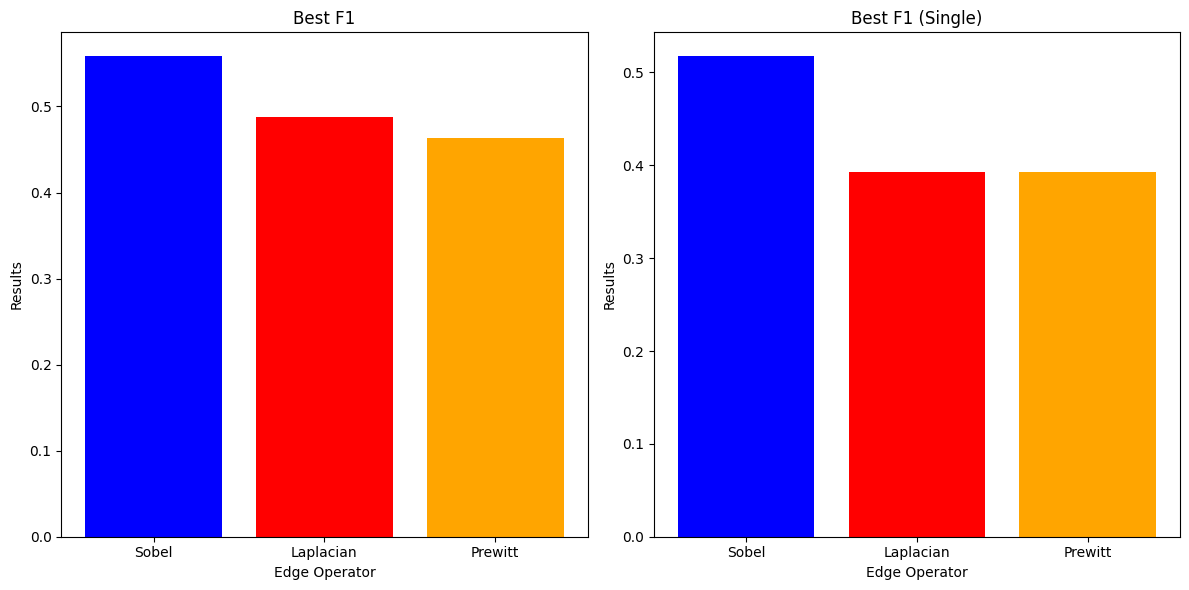

In [34]:
best_f1 = [best_result_sobel.f1, best_result_laplacian.f1, best_result_prewitt.f1]
best_f1_single = [best_result_single_sobel.f1, best_result_single_laplacian.f1, best_result_single_laplacian.f1]
x_labels = ['Sobel', 'Laplacian', 'Prewitt']
colors = ['blue', 'red', 'orange']


# Create a figure and two subplots (axes)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first bar graph
ax1.bar(x_labels, best_f1, color=colors)
ax1.set_title('Best F1')
ax1.set_xlabel('Edge Operator')
ax1.set_ylabel('Results')

# Plot the second bar graph
ax2.bar(x_labels, best_f1_single, color=colors)
ax2.set_title('Best F1 (Single)')
ax2.set_xlabel('Edge Operator')
ax2.set_ylabel('Results')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()